/home/ipl_dl2/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ipl_dl2/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/90 | LR: 0.01000
Train Loss: 3.2559, Train Acc: 14.27% | Val Loss: 2.9486, Val Acc: 18.22%
Epoch 2/90 | LR: 0.02000
Train Loss: 2.7317, Train Acc: 24.59% | Val Loss: 2.4865, Val Acc: 28.00%
Epoch 3/90 | LR: 0.03000
Train Loss: 2.4446, Train Acc: 31.04% | Val Loss: 2.5613, Val Acc: 29.33%
Epoch 4/90 | LR: 0.04000
Train Loss: 2.2284, Train Acc: 36.06% | Val Loss: 2.6264, Val Acc: 26.44%
Epoch 5/90 | LR: 0.05000
Train Loss: 2.0479, Train Acc: 40.58% | Val Loss: 2.2198, Val Acc: 36.67%
Epoch 6/90 | LR: 0.05000
Train Loss: 1.8255, Train Acc: 46.11% | Val Loss: 2.1561, Val Acc: 36.00%
Epoch 7/90 | LR: 0.04998
Train Loss: 1.6696, Train Acc: 50.50% | Val Loss: 2.0163, Val Acc: 42.44%
Epoch 8/90 | LR: 0.04993
Train Loss: 1.5497, Train Acc: 53.26% | Val Loss: 1.8888, Val Acc: 46.00%
Epoch 9/90 | LR: 0.04985
Train Loss: 1.4719, Train Acc: 55.41% | Val Loss: 2.0114, Val Acc: 43.11%
Epoch 10/90 | LR: 0.04973
Train Loss: 1.4172, Train Acc: 57.02% | Val Loss: 1.9238, Val Acc: 44.89%
Epoch 11/

/home/ipl_dl2/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ipl_dl2/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


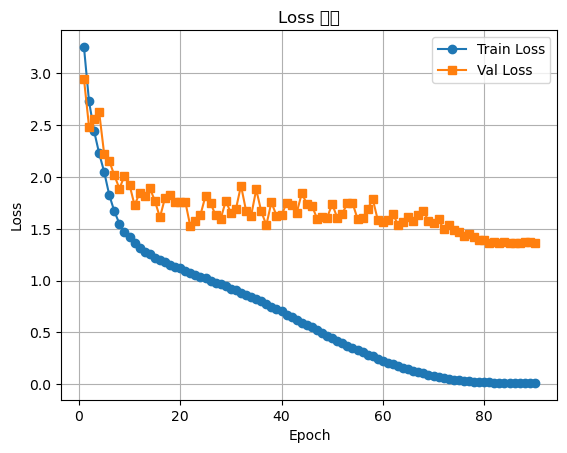

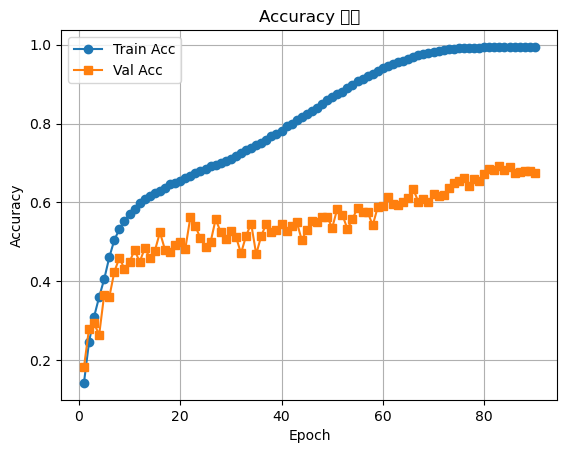

原生 ResNet18 參數量: 11.228M, FLOPs: 595.487M
        Method   Params     MAdds  Top-1 Acc (%)
0  原生 ResNet18  11.228M  595.487M      70.666667


In [3]:
# %% [markdown]
# 原生 ResNet18 訓練與評估完整腳本

# %%
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from thop import profile, clever_format

# %%
# 原生 ResNet18 定義
# 如果輸入通道不為 3，會調整第一層卷積

def raw_resnet18(num_classes=100, in_channels=3):
    model = models.resnet18(pretrained=False)
    if in_channels != 3:
        model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# %%
# 自訂 Dataset
class ImageNetMiniDataset(Dataset):
    def __init__(self, list_file, transform=None):
        self.image_paths = []
        self.labels = []
        with open(list_file, 'r') as f:
            for line in f:
                path, label = line.strip().split()
                self.image_paths.append(path)
                self.labels.append(int(label))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# %%
# 影像前處理
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# %%
# 資料讀取與 DataLoader
batch_size = 64  # 視顯存調整

datasets = {
    'train': ImageNetMiniDataset('train.txt', transform=train_transforms),
    'val':   ImageNetMiniDataset('val.txt',   transform=val_transforms),
    'test':  ImageNetMiniDataset('test.txt',  transform=val_transforms)
}

dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size,
                      shuffle=(phase=='train'), num_workers=4)
    for phase in ['train', 'val', 'test']
}

# %%
# 設定裝置與模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = raw_resnet18(num_classes=100, in_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

# Cosine annealing + warm-up 學習率調整

def adjust_learning_rate(optimizer, epoch, total_epochs,
                         initial_lr=0.05, warmup_epochs=5):
    if epoch < warmup_epochs:
        lr = initial_lr * (epoch + 1) / warmup_epochs
    else:
        lr = initial_lr * 0.5 * (1 + math.cos(
            math.pi * (epoch-warmup_epochs) / (total_epochs-warmup_epochs)
        ))
    for g in optimizer.param_groups:
        g['lr'] = lr
    return lr

# %%
# 訓練與驗證
num_epochs = 90
csv_path = 'metrics_history.csv'
with open(csv_path, 'w') as f:
    f.write('epoch,train_loss,train_acc,val_loss,val_acc\n')

for epoch in range(num_epochs):
    # 訓練階段
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    lr = adjust_learning_rate(optimizer, epoch, num_epochs)
    print(f"Epoch {epoch+1}/{num_epochs} | LR: {lr:.5f}")

    for imgs, labels in dataloaders['train']:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # 驗證階段
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in dataloaders['val']:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds==labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc  = val_correct / val_total

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    with open(csv_path, 'a') as f:
        f.write(f"{epoch+1},{train_loss},{train_acc},{val_loss},{val_acc}\n")

# %%
# 定義單通道/多通道測試函式

def evaluate_with_channel_mask(model, loader, mask):
    model.eval()
    correct = 0
    total = 0
    mask_tensor = torch.tensor(mask, dtype=torch.float32).view(1,3,1,1).to(device)
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs * mask_tensor
            preds = model(imgs).argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    return correct/total

# %%
# 測試不同通道組合
masks = {
    'RGB': (1,1,1), 'RG': (1,1,0), 'RB': (1,0,1),
    'GB': (0,1,1), 'R': (1,0,0), 'G': (0,1,0), 'B': (0,0,1)
}
accuracy = {}
for name, mask in masks.items():
    acc = evaluate_with_channel_mask(model, dataloaders['test'], mask)
    accuracy[name] = acc
    print(f"{name} 通道測試準確率: {acc*100:.2f}%")

# %%
# 畫圖及結果表格
metrics = pd.read_csv(csv_path)

# Loss 與 Accuracy 曲線
plt.figure()
plt.plot(metrics['epoch'], metrics['train_loss'], label='Train Loss', marker='o')
plt.plot(metrics['epoch'], metrics['val_loss'],   label='Val Loss', marker='s')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss 曲線'); plt.grid(True)
plt.show()

plt.figure()
plt.plot(metrics['epoch'], metrics['train_acc'], label='Train Acc', marker='o')
plt.plot(metrics['epoch'], metrics['val_acc'],   label='Val Acc', marker='s')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy 曲線'); plt.grid(True)
plt.show()

# %%
# 使用 THOP 計算參數量與 FLOPs
input_size = (3,128,128)
sample = torch.randn(1,*input_size).to(device)
flops, params = profile(model, inputs=(sample,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"原生 ResNet18 參數量: {params}, FLOPs: {flops}")

# 比較表（僅原生）
df = pd.DataFrame([
    ['原生 ResNet18', params, flops, accuracy['RGB']*100]
], columns=['Method', 'Params', 'MAdds', 'Top-1 Acc (%)'])
print(df)
